# Generate Embeddings

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('./data/IMDB Dataset.csv')

test_size = 0.2  # 20% of the data for testing
val_size = 0.1   # 10% of the data for validation
random_state = 11  

train_df, test_val_df = train_test_split(df, test_size=test_size + val_size, shuffle=True, random_state=random_state)
test_df, val_df = train_test_split(test_val_df, test_size=val_size/(test_size + val_size), shuffle=True, random_state=random_state)


In [31]:
from sentence_transformers import SentenceTransformer
import numpy as np
import os

model_name = 'paraphrase-MiniLM-L6-v2'  # You can choose a different model from Sentence Transformers

if f'train_{model_name}_embeddings.npy' not in os.listdir('./data/'):
    model = SentenceTransformer(model_name)
    train_embeddings = model.encode(train_df['review'].tolist())
    np.save('./data/' + f'train_{model_name}_embeddings.npy', train_embeddings)
else:
    train_embeddings = np.load('./data/' + f'train_{model_name}_embeddings.npy')
if f'val_{model_name}_embeddings.npy' not in os.listdir('./data/'):
    model_name = 'paraphrase-MiniLM-L6-v2'  # You can choose a different model from Sentence Transformers
    model = SentenceTransformer(model_name)
    val_embeddings = model.encode(val_df['review'].tolist())
    np.save('./data/' + f'val_{model_name}_embeddings.npy', val_embeddings)
else:
    val_embeddings = np.load('./data/' + f'val_{model_name}_embeddings.npy')
if f'test_{model_name}_embeddings.npy' not in os.listdir('./data/'):
    model_name = 'paraphrase-MiniLM-L6-v2'  # You can choose a different model from Sentence Transformers
    model = SentenceTransformer(model_name)
    test_embeddings = model.encode(test_df['review'].tolist())
    np.save('./data/' + f'test_{model_name}_embeddings.npy', test_embeddings)
else:
    test_embeddings = np.load('./data/' + f'test_{model_name}_embeddings.npy')

In [34]:
train_embeddings.shape

(34999, 384)

# PCA

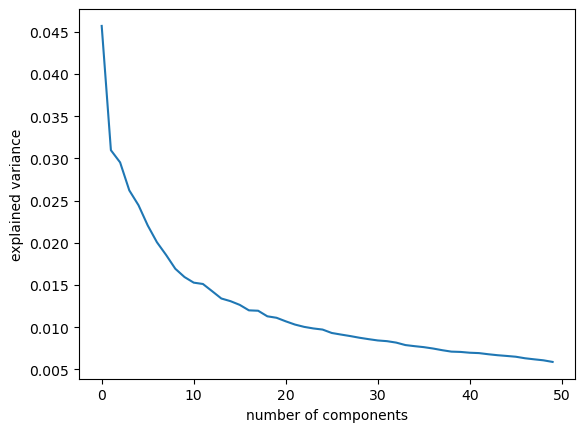

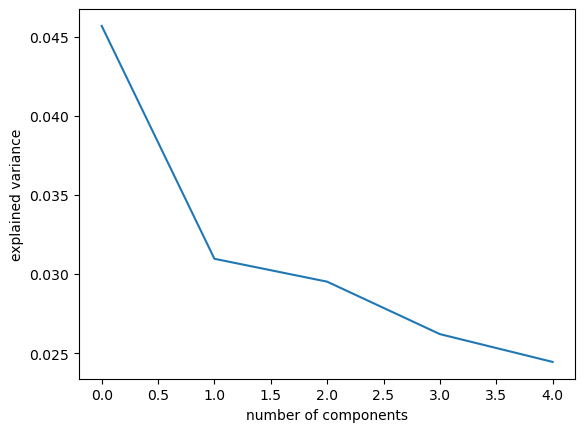

In [32]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

n_components = 50  # Adjust this based on your requirements
pca = PCA(n_components=n_components)
embeddings_pca = pca.fit_transform(train_embeddings) # (50000, 3)
explained_variance_ratio = pca.explained_variance_ratio_
plt.plot(np.arange(len(explained_variance_ratio)), explained_variance_ratio)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()

plt.plot(np.arange(len(explained_variance_ratio[:5])), explained_variance_ratio[:5])
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.show()


# KNN

In [35]:
table = [list(range(1,22,2))]
for n_components in range(1,11):
    # n_components = 3  # Adjust this based on your requirements
    pca = PCA(n_components=n_components)

    train_embeddings_pca = pca.fit_transform(train_embeddings) # (n_samples, n_components)
    val_embeddings_pca = pca.fit_transform(val_embeddings) 
    test_embeddings_pca = pca.fit_transform(test_embeddings) 

    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score

    def get_labels(x):
        return (x['sentiment'] == 'positive').astype(int).to_numpy()

    train_labels = get_labels(train_df) 
    val_labels = get_labels(val_df) 
    test_labels = get_labels(test_df) 

    # Create a KNN classifier
    accuracies = [n_components]
    for k in range(1,22,2):
        knn_model = KNeighborsClassifier(n_neighbors=k)
        knn_model.fit(train_embeddings_pca, train_labels)
        pred_val_labels = knn_model.predict(val_embeddings_pca)

        # Evaluate the model
        accuracy = accuracy_score(val_labels, pred_val_labels)
        accuracies.append(accuracy)
        # print(f'n = {n_components}\nk = {k}\nAccuracy: {accuracy:.2f}\n')
    table.append(accuracies)

from tabulate import tabulate
print('No. components in PCA on y-axis, K for KNN on x-axis:')
print(tabulate(table, headers='firstrow', tablefmt="heavy_outline"))


No. components in PCA on y-axis, K for KNN on x-axis:
┏━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┓
┃    ┃        1 ┃        3 ┃        5 ┃        7 ┃        9 ┃       11 ┃       13 ┃       15 ┃       17 ┃       19 ┃       21 ┃
┣━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━╋━━━━━━━━━━┫
┃  1 ┃ 0.5019   ┃ 0.508898 ┃ 0.514097 ┃ 0.519696 ┃ 0.514897 ┃ 0.525095 ┃ 0.527894 ┃ 0.531094 ┃ 0.525095 ┃ 0.531094 ┃ 0.534493 ┃
┃  2 ┃ 0.531494 ┃ 0.54929  ┃ 0.54809  ┃ 0.554889 ┃ 0.558288 ┃ 0.560688 ┃ 0.559288 ┃ 0.559888 ┃ 0.560488 ┃ 0.562088 ┃ 0.564887 ┃
┃  3 ┃ 0.467506 ┃ 0.457708 ┃ 0.45111  ┃ 0.454509 ┃ 0.44951  ┃ 0.44771  ┃ 0.445111 ┃ 0.446111 ┃ 0.446911 ┃ 0.447111 ┃ 0.44971  ┃
┃  4 ┃ 0.446511 ┃ 0.421316 ┃ 0.413917 ┃ 0.407918 ┃ 0.403519 ┃ 0.407119 ┃ 0.404119 ┃ 0.402519 ┃ 0.39972  ┃ 0.403319 ┃ 0.404519 ┃
┃  5 ┃ 0.446711 ┃ 0.422116 ┃ 0.414517 ┃ 0.411918 ┃